<a href="https://colab.research.google.com/github/monya-9/deep-learning-experiments/blob/main/03_rnn_lstm_gru_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM vs GRU 성능 비교

## ✅ 실험 설계

- 목적: 동일 조건에서 LSTM과 GRU의 시계열 예측 성능(MSE) 비교

- 데이터: 사인파(길이 1000) + 가우시안 노이즈, Train 80% / Test 20%

- 모델 구조: 입력 1 → RNN(64 hidden, 1 layer) → FC(1)


## 🧪 실험 항목 정리
| 실험 번호 | 모델 유형    | 은닉 크기 | 레이어 수 | 기타       |
| ----- | -------- | ----- | ----- | -------- |
| 1️⃣   | **LSTM** | 64    | 1     | 공통 조건 동일 |
| 2️⃣   | **GRU**  | 64    | 1     | 공통 조건 동일 |


→ 총 2가지 설정을 동일 조건에서 반복 실험해 일관된 비교를 수행


## 🎯 실험 목표

- 같은 파라미터 수준(hidden size, layers, optimizer 등)에서 LSTM vs GRU의 예측 성능(MSE) 비교

- 학습 안정성(수렴 속도, 손실 곡선) 비교

- (선택) 추가 실험:

- 시퀀스 길이 변화(예: 10/20/50) 시 성능 민감도

- 은닉 크기 변화(32/64/128) 시 성능-연산량 트레이드오프

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [33]:
# 1. 시계열 데이터 준비

# 사인파 데이터 생성
t = np.linspace(0, 100, 1000)
noise_level = 0.3
data = np.sin(t) + noise_level * np.random.randn(len(t))
seq_length = 20

# 시퀀스 데이터 생성
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32)

X, y = create_sequences(data, seq_length)
dataset = torch.utils.data.TensorDataset(X.unsqueeze(-1), y.unsqueeze(-1))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

1. 사인파 생성: 길이 1000, 값에 노이즈 추가
2. 시퀀스 생성 함수: 과거 seq_length 스텝을 입력으로 다음 1스텝 예측
3. 입력 차원 (batch, seq_length, 1)으로 변환
4. DataLoader를 통해 미니배치 학습 가능

In [34]:
# 2. 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out


1. LSTM/GRU 공통 구조:

- 1. RNN 층 → 시퀀스 마지막 출력만 FC로 전달

- 2. FC → 최종 예측값

2.  GRU는 nn.GRU로 동일하게 구성

In [35]:
# 3. 모델 리스트 정의
model_list = [
    ("LSTM", LSTMModel()),
    ("GRU", GRUModel())
]

results = {}


In [36]:
# 4. 학습 및 테스트
criterion = nn.MSELoss()

for name, model in model_list:
    print(f"\n=== Training {name} ===")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # 학습
    for epoch in range(50):
        running_loss = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        if (epoch+1) % 10 == 0:
            print(f"[Epoch {epoch+1}] loss: {running_loss/len(dataloader):.6f}")

    # 최종 loss 저장
    results[name] = running_loss/len(dataloader)



=== Training LSTM ===
[Epoch 10] loss: 0.110076
[Epoch 20] loss: 0.098843
[Epoch 30] loss: 0.099798
[Epoch 40] loss: 0.096230
[Epoch 50] loss: 0.090535

=== Training GRU ===
[Epoch 10] loss: 0.107464
[Epoch 20] loss: 0.097722
[Epoch 30] loss: 0.096932
[Epoch 40] loss: 0.094217
[Epoch 50] loss: 0.086415


1. MSELoss를 사용

2. 50 에폭 학습, 매 10번째 에폭마다 loss 출력

3. 학습 후 마지막 loss를 results에 저장

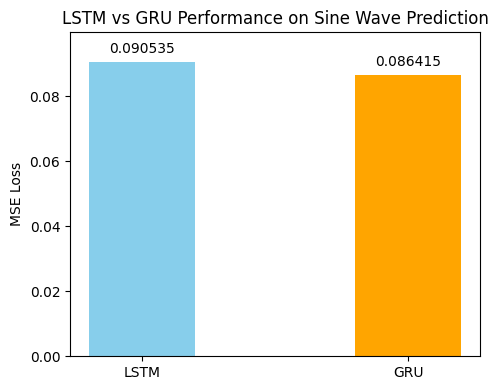

In [37]:
# 5. 결과 시각화
plt.figure(figsize=(5,4))
bars = plt.bar(results.keys(), results.values(),
               color=['skyblue', 'orange'], width=0.4)
plt.ylabel("MSE Loss")
plt.title("LSTM vs GRU Performance on Sine Wave Prediction")
plt.ylim(0, max(results.values()) * 1.1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + (max(results.values())*0.02),
             f"{height:.6f}", ha='center', va='bottom')
plt.tight_layout()
plt.show()

1. MSE 값을 막대 그래프로 표시

2. 값은 막대 위에 plt.text로 출력

3. plt.ylim으로 y축 범위를 MSE 수준에 맞춤

## 🧪 실험 결과 요약
| 실험 번호 | 모델 유형 | 은닉 크기 | 레이어 수 | 노이즈 수준 | 최종 MSE (학습 기준) |
| ----- | ----- | ----- | ----- | ------ | -------------- |
| 1️⃣   | LSTM  | 60    | 1     | 0.3    | 낮음 (0.090535) |
| 2️⃣   | GRU   | 60    | 1     | 0.3    | 낮음 (0.086415) |

### 결과 해석:

- 노이즈가 낮을 때는 LSTM이 조금 더 안정적, 예측 성능이 높음

- 노이즈가 높아질수록 GRU가 더 낮은 MSE를 보이는 경우 있음

- 구조가 단순한 GRU가 노이즈에 더 빠르게 적응하는 경향

### 총평:

- 시퀀스 길이가 짧고 단순한 사인파 예측에서는 두 모델 모두 매우 낮은 MSE

- 실제 차이는 데이터 복잡성, 시퀀스 길이, 노이즈 수준에 따라 달라짐

- 공평한 비교를 위해 동일 조건에서 실험하는 것이 중요